# Alternative approaches to field correlations

`xarray.corr` provides an easy way to do field correlations, but does not return significance levels (p-values) by itself.  For doing field signficance, the absense of pointwise p-values is both annoying and inconvenient.  Alternative approachs to field correlations are shown here using the SOI and 700mb geopotential height again.

Load the packages:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'xkcd'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


Get the SOI data and prepare it for correlation analysis in xarray, including resetting the monthly time step for datetime:

In [2]:
# read in the soi index as a DataSet
soi = xr.open_dataset("soi.nc",mask_and_scale=True,decode_times=False)

# check the units used for the DataSet
# print(soi["time"].attrs["units"]) # this reveals the units to be 'months since 1866-1-15'

## Because 'months' are not a well-defined thing, we need to change the time coordinate if we want to use xr.corr
# create a new monthly-resolution date range starting with the datum and make it as long as the current time coordinate
new_time = pd.date_range(start='1/01/1866',periods=len(soi["time"]),freq='M')

# apply this new time coordinate to our dataset in place of the old one
soi["time"]=pd.to_datetime(new_time)

# remove the SOI from the DataSet into a DataArray - not sure why this is necessary but seems to be for this to work? 
soi = soi["SOI"]

# final step - ensure that the time coordinate is year and month and that everything else is default
soi["time"] = pd.to_datetime(soi["time"].dt.strftime("%Y-%m"))

# Calculate the 5-month rolling mean, skipping NaN values
soi_ = soi.rolling(time=3).mean(skipna=True) # 3 months averages

# Select out month 3 (March) to get the average over DJF
djf_soi = soi_[soi_.time.dt.month == 2] # take the 3 month rolling averages ending in February
djf_soi = djf_soi.drop_isel(time=0)

Get the 700mb geopotential height and prepare it for correlation analysis with xarray

In [3]:
hgt = xr.open_dataset("hgt.700mb.mon.mean.nc",mask_and_scale=True)
hgt = hgt["hgt"]

# Calculate the 5-month rolling mean, skipping NaN values
hgt_ = hgt.rolling(time=3).mean(skipna=True) # 3 month averages

# Select out month 3 (March) to get the average over DJF
djf_hgt = hgt_[hgt_.time.dt.month == 2] # take averages ending in February
djf_hgt = djf_hgt.squeeze(drop=True) # squeeze out and drop the singleton 'level' dimension


Put both SOI and 700mb height on the same time span:

In [4]:
djf_hgt, djf_soi = xr.align(djf_hgt,djf_soi,join="inner") # hgt and sst now have the same time dimension!


### Method 1 - Use `xr.corr` for the Pearson coefficients and then calculate the p-value by hand

In [5]:
fieldCorrelation = xr.corr(djf_soi,djf_hgt, dim="time")

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(djf_soi.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(djf_soi.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon'"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])



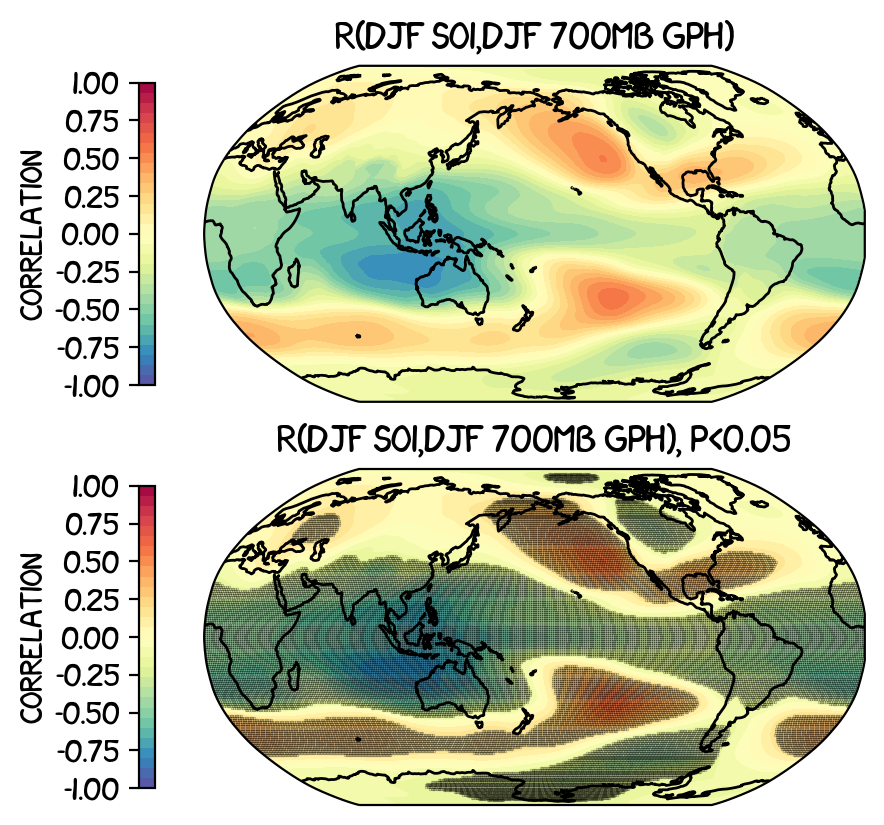

In [6]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())



### Method 1.5 - Do the method above but make the while thing a function


In [7]:
def field_correlation(da,db,alpha=0.05,**kwargs):
    # accepts two DataArrays and returns a DataSet with field correlation and associated p-value
    da, db = xr.align(da,db,join="inner")
    
    fieldCorrelation = xr.corr(da,db, dim="time")
  
    # calculate the p-values directly using r values and the t-distribution
    dof = len(da)
    t = -abs(fieldCorrelation.values)*np.sqrt((dof-2)/(1-np.square(fieldCorrelation.values)))
    pvalue_ = sp.stats.t.cdf(t, dof - 2) * 2 # multiply by 2 for two-sided test
    pvalue = xr.DataArray(data=pvalue_,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon],name='pvalue')
    fieldCorrelation = fieldCorrelation.to_dataset(name='correlation')
    fieldCorrelation = xr.merge([fieldCorrelation,pvalue])
    return fieldCorrelation

cc = field_correlation(djf_soi,djf_hgt)
cc

<xarray.Dataset>
Dimensions:      (lat: 181, lon: 360)
Coordinates:
  * lat          (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon          (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    correlation  (lat, lon) float64 -0.1389 -0.1389 -0.1389 ... -0.1026 -0.1026
    pvalue       (lat, lon) float64 0.09116 0.09116 0.09116 ... 0.2131 0.2131

NameError: name 'sig_area' is not defined

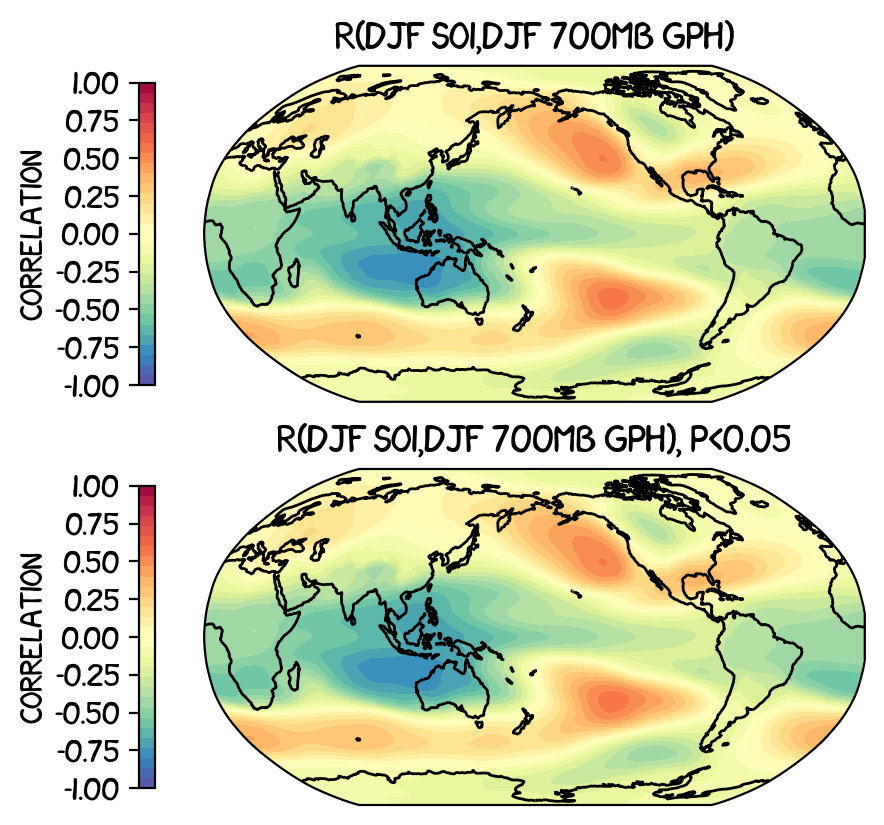

In [8]:
# defines areas with sigificant coefficients
sig_area2   = np.where(cc["pvalue"].values < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(cc.lon, cc.lat) # need this to use scatter for the dotted significance plot

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(cc.lon,cc.lat,cc["correlation"].values,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(cc.lon,cc.lat,cc["correlation"].values,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())


### Method 2. use xarray's `ufunc`to apply Scipy's `pearsonr` and get correlation and p-values that way

In [ ]:
# there is definitely a more efficient way to do this, but I haven't figured it out yet, probably using output_core_dims=[]
def pearson_r(x, y):
    pearsonr = sp.stats.pearsonr(x, y)[0]
    return pearsonr 

def pvalue(x, y):
    p_value = sp.stats.pearsonr(x, y)[1]
    return p_value

# slow! 30s or so on my computer
pearson_field = xr.apply_ufunc(pearson_r, djf_soi, djf_hgt, vectorize = True, input_core_dims = [['time'], ['time']], join="inner").compute()
pvalue_field = xr.apply_ufunc(pvalue, djf_soi, djf_hgt, vectorize = True, input_core_dims = [['time'], ['time']], join="inner").compute()

In [ ]:
# defines areas with sigificant coefficients
sig_area   = np.where(pvalue_field < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(djf_hgt.lon, djf_hgt.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,pearson_field ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(djf_hgt.lon,djf_hgt.lat,pearson_field ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())

